<a href="https://colab.research.google.com/github/sekihiro/Colabo/blob/master/TextClassification_Batch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## PyTorchを使ってLSTMで文章分類 (Batch対応)
- 対象：livedoorニュースのタイトル文
- https://qiita.com/m__k/items/841950a57a0d7ff05506
- https://qiita.com/m__k/items/db1a81bb06607d5b0ec5

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


### livedoor ニュースコーパス 取得

In [0]:
%cd "/content/drive/My Drive/git/LDCC/data"
%ls -al
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz
!tar zxvf ldcc-20140209.tar.gz
%ls -al

/content/drive/My Drive/git/LDCC/data
total 0
--2020-01-05 02:36:31--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
Resolving www.rondhuit.com (www.rondhuit.com)... 59.106.19.174
Connecting to www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8855190 (8.4M) [application/x-gzip]
Saving to: ‘ldcc-20140209.tar.gz’

ldcc-20140209.tar.g 100%[===================>]   8.44M  1.77MB/s    in 6.4s    

2020-01-05 02:36:38 (1.32 MB/s) - ‘ldcc-20140209.tar.gz’ saved [8855190/8855190]

text/
text/CHANGES.txt
text/dokujo-tsushin/
text/it-life-hack/
text/kaden-channel/
text/livedoor-homme/
text/movie-enter/
text/peachy/
text/README.txt
text/smax/
text/sports-watch/
text/topic-news/
text/topic-news/LICENSE.txt
text/topic-news/topic-news-5903225.txt
text/topic-news/topic-news-5903373.txt
text/topic-news/topic-news-5907376.txt
text/topic-news/topic-news-5908396.txt
text/topic-news/topic-news-5910461.txt
text/topic-news/to

In [2]:
%cd "/content/drive/My Drive/git/LDCC/data/text/"
%ls -al

/content/drive/My Drive/git/LDCC/data/text
total 36
drwx------ 2 root root 4096 Feb  9  2014 dokujo-tsushin/
drwx------ 2 root root 4096 Feb  9  2014 it-life-hack/
drwx------ 2 root root 4096 Feb  9  2014 kaden-channel/
drwx------ 2 root root 4096 Feb  9  2014 livedoor-homme/
drwx------ 2 root root 4096 Feb  9  2014 movie-enter/
drwx------ 2 root root 4096 Feb  9  2014 peachy/
drwx------ 2 root root 4096 Feb  9  2014 smax/
drwx------ 2 root root 4096 Feb  9  2014 sports-watch/
drwx------ 2 root root 4096 Feb  9  2014 topic-news/


In [3]:
!nvidia-smi

Tue Feb 11 07:41:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.48.02    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [4]:
!nvcc -V

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2018 NVIDIA Corporation
Built on Sat_Aug_25_21:08:01_CDT_2018
Cuda compilation tools, release 10.0, V10.0.130


In [5]:
!cat /usr/include/cudnn.h | grep CUDNN_MAJOR -A 2

#define CUDNN_MAJOR 7
#define CUDNN_MINOR 6
#define CUDNN_PATCHLEVEL 5
--
#define CUDNN_VERSION (CUDNN_MAJOR * 1000 + CUDNN_MINOR * 100 + CUDNN_PATCHLEVEL)

#include "driver_types.h"


### **MeCab** を Google-Colaboratory で使えるようにする

In [6]:
!apt install aptitude
!aptitude install mecab libmecab-dev mecab-ipadic-utf8 git make curl xz-utils file -y
!pip install mecab-python3

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'apt autoremove' to remove it.
The following additional packages will be installed:
  aptitude-common libcgi-fast-perl libcgi-pm-perl libclass-accessor-perl
  libcwidget3v5 libencode-locale-perl libfcgi-perl libhtml-parser-perl
  libhtml-tagset-perl libhttp-date-perl libhttp-message-perl libio-html-perl
  libio-string-perl liblwp-mediatypes-perl libparse-debianchangelog-perl
  libsigc++-2.0-0v5 libsub-name-perl libtimedate-perl liburi-perl libxapian30
Suggested packages:
  aptitude-doc-en | aptitude-doc apt-xapian-index debtags tasksel
  libcwidget-dev libdata-dump-perl libhtml-template-perl libxml-simple-perl
  libwww-perl xapian-tools
The following NEW packages will be installed:
  aptitude aptitude-common libcgi-fast-perl libcgi-pm-perl
  libclass-accessor-perl libcwidget3v5 libencode-l

In [0]:
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import easydict
import time
import math
import random
from tqdm import tqdm
import pprint
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import cloudpickle
import os
from glob import glob
import pandas as pd
import linecache
import MeCab
import re
import collections
%matplotlib inline

In [8]:
# 再現性確保
def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    return seed

# 再現性確保
ret = seed_everything(1234)
print('seed : {}'.format(ret))

# select device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('device : {}'.format(device))

seed : 1234
device : cuda


### データ準備

In [9]:
# テキスト内容を確認１
!head "/content/drive/My Drive/git/LDCC/data/text/dokujo-tsushin/dokujo-tsushin-4778030.txt"

http://news.livedoor.com/article/detail/4778030/
2010-05-22T14:30:00+0900
友人代表のスピーチ、独女はどうこなしている？
　もうすぐジューン・ブライドと呼ばれる６月。独女の中には自分の式はまだなのに呼ばれてばかり……という「お祝い貧乏」状態の人も多いのではないだろうか？　さらに出席回数を重ねていくと、こんなお願いごとをされることも少なくない。

　「お願いがあるんだけど……友人代表のスピーチ、やってくれないかな？」

　さてそんなとき、独女はどう対応したらいいか？

　最近だとインターネット等で検索すれば友人代表スピーチ用の例文サイトがたくさん出てくるので、それらを参考にすれば、無難なものは誰でも作成できる。しかし由利さん（33歳）はネットを参考にして作成したものの「これで本当にいいのか不安でした。一人暮らしなので聞かせて感想をいってくれる人もいないし、かといって他の友人にわざわざ聞かせるのもどうかと思うし……」ということで活用したのが、なんとインターネットの悩み相談サイトに。そこに作成したスピーチ文を掲載し「これで大丈夫か添削してください」とメッセージを送ったというのである。


In [10]:
# テキスト内容を確認２
!head "/content/drive/My Drive/git/LDCC/data/text/it-life-hack/it-life-hack-6292880.txt"

http://news.livedoor.com/article/detail/6292880/
2012-02-19T13:00:00+0900
旧式Macで禁断のパワーアップ！最新PCやソフトを一挙にチェック【ITフラッシュバック】
テレビやTwitterと連携できるパソコンや、プロセッサや切り替わるパソコンなど、面白いパソコンが次から次へと登場した。旧式Macの禁断ともいえるパワーアップ方法から、NECの最新PC、話題のThinkPad X1 Hybrid、新セキュリティソフトまで一挙に紹介しよう。

■インテル SSD 520をMacに装着！旧式Macはどれほど高速化するのか (上)
インテルが最新SSD「520シリーズ」を発売した。現行SSDの中でもトップクラスの性能を誇る同製品を、旧型Macの高速化を図るというポイントでレビューしてみた。少し風変わりなレビューとなるが、どの程度の効果があるか、期待大である。


■http://itlifehack.jp/archives/6716997.html


In [0]:
BASE_PATH = "/content/drive/My Drive/git/LDCC/"
DATA_PATH = BASE_PATH + 'data/text/'
PICKLE_PATH = BASE_PATH + 'data/ldcc.pkl'

In [12]:
# LDCCテキストファイルからタイトル行をDateFrameに格納し、pickle形式で保存

# カテゴリを配列で取得
categories = [name for name in os.listdir(DATA_PATH) if os.path.isdir(DATA_PATH + name)]
print(categories)
time.sleep(1)
# ['movie-enter', 'it-life-hack', 'kaden-channel', 'topic-news', 'livedoor-homme', 'peachy', 'sports-watch', 'dokujo-tsushin', 'smax']

if os.path.isfile(PICKLE_PATH):
    print(PICKLE_PATH + ' is exists ... ')
else:
    # データフレーム作成
    datasets = pd.DataFrame(columns=["title", "category"])
    for cat in categories:
        path = DATA_PATH + cat + "/*.txt"
        files = glob(path)
        print('\n' + cat + '\n')
        time.sleep(1)
        for text_name in tqdm(files):
            # 各テキストファイルの3行目にタイトル文字列の記載がある
            title = linecache.getline(text_name, 3)
            s = pd.Series([title, cat], index=datasets.columns)
            datasets = datasets.append(s, ignore_index=True)

    # データフレームシャッフル
    print('\n len : {}'.format(len(datasets)))
    datasets = datasets.sample(frac=1).reset_index(drop=True)
    datasets.head()

    # PICKLE形式で保存
    datasets.to_pickle(PICKLE_PATH)
    print(PICKLE_PATH + ' is saved ...')

['dokujo-tsushin', 'livedoor-homme', 'kaden-channel', 'smax', 'topic-news', 'peachy', 'movie-enter', 'it-life-hack', 'sports-watch']
/content/drive/My Drive/git/LDCC/data/ldcc.pkl is exists ... 


In [13]:
# PICKLE形式のDataFrameを読み込む
datasets = pd.read_pickle(PICKLE_PATH)
datasets.head()

,title,category
0,貞子がついに上戸彩と並んだ！ 野球カード化が決定\n,movie-enter
1,人間のボクシングは死に絶え、時代は“最強”ロボット格闘技へ\n,movie-enter
2,乗り換えたいけど、スマホって本当に便利？ ケータイ大好きOLの女子座談会へ潜入\n,livedoor-homme
3,くさったよめがあらわれた！vol.05「自分を変えたい…それは楽しめることをみつけること!!...,dokujo-tsushin
4,ウリナリ的な挑戦企画が人気か？ 日テレ「ヒルナンデス！」が視聴率初の昼トップに【話題】\n,kaden-channel


### データ前処理

PyTorchでLSTMをする際、食わせるインプットデータは３次元のテンソルある必要があります。<br>具体的には、文章の長さ × バッチサイズ × ベクトル次元数 となっています。<br>
今回のインプットデータは文章（livedoorニュースのタイトル文）であり、この文章を3次元テンソルに変換する必要があります。<br>
実際のデータ（ニュース記事のタイトル）の長さ（厳密には形態素の数）は異なりますが、データをバッチ化してまとめてLSTMに流すために文章の系列の長さを揃える必要があります。
系列の長さを揃えるために単語リストに新しく<pad>（単語ID＝0）を追加して短い文章を0パディングします。

単語のベクトルは例えばWord2Vecで学習済みのものがあればそれを使う方が精度が良いらしいですが、<br>一旦はPyTorchの torch.nn.Embedding を使いましょう。<br>
こいつの詳細はPyTorchのチュートリアルに任せますが、要はランダムな単語ベクトル群を生成してくれるやつです。<br>実際に使ってみると分かりやすいです。

In [14]:
# torch.nn.Embedding の使い方

# 以下の宣言で行が単語ベクトル、列が単語のインデックスのマトリクスを生成してる感じ
embeds = nn.Embedding(10, 6) # (Embedding(単語の合計数, ベクトル次元数))

# ３行目の要素を取り出したいならば
w1 = torch.tensor([2])
print(embeds(w1))
# tensor([[-1.5947, -0.8387,  0.7669, -0.9644, -0.7902,  2.7167]],
#        grad_fn=<EmbeddingBackward>)

# 3行目、5行目、１０行目の要素を取り出したいならば、
w2 = torch.tensor([2,4,9])
print(embeds(w2))
# tensor([[-1.5947, -0.8387,  0.7669, -0.9644, -0.7902,  2.7167],
#        [ 0.0405,  1.4236,  0.1947,  0.2609,  0.2047, -1.4964],
#        [ 1.7325, -0.2543, -0.5139, -0.9527, -0.1344,  0.0984]],
#       grad_fn=<EmbeddingBackward>)

tensor([[-0.3424, -1.4020,  0.3206, -1.0219,  0.7988, -0.0923]],
       grad_fn=<EmbeddingBackward>)
tensor([[-0.3424, -1.4020,  0.3206, -1.0219,  0.7988, -0.0923],
        [-0.1706, -1.4594,  0.2207,  0.2463, -1.3248,  0.6970],
        [ 1.0534,  0.3692,  0.0628, -0.3297, -1.7970,  0.8728]],
       grad_fn=<EmbeddingBackward>)


In [15]:
# 文章を単語IDの系列データとして変換する方法の確認

tagger = MeCab.Tagger("-Owakati")

def make_wakati(sentence):
    # MeCabで分かち書き
    sentence = tagger.parse(sentence)
    # 半角全角英数字除去
    sentence = re.sub(r'[0-9０-９a-zA-Zａ-ｚＡ-Ｚ]+', " ", sentence)
    # 記号もろもろ除去
    sentence = re.sub(r'[\．_－―─！＠＃＄％＾＆\-‐|\\＊\“（）＿■×+α※÷⇒—●★☆〇◎◆▼◇△□(：〜～＋=)／*&^%$#@!~`){}［］…\[\]\"\'\”\’:;<>?＜＞〔〕〈〉？、。・,\./『』【】「」→←○《》≪≫\n\u3000]+', "", sentence)
    # スペースで区切って形態素の配列へ
    wakati = sentence.split(" ")
    # 空の要素は削除
    wakati = list(filter(("").__ne__, wakati))
    return wakati

# テスト
test = "今日はそういう日だったのか！Googleロゴが変わっている理由"
print('make_wakati TEST:')
print(make_wakati(test))

# 単語ID辞書を作成する
word2index = {}

# 系列を揃えるためのパディング文字列<pad>を追加
# パディング文字列のIDは0とする
word2index.update({"<pad>":0})

for title in datasets["title"]:
    wakati = make_wakati(title)
    for word in wakati:
        if word in word2index: continue
        word2index[word] = len(word2index)
print("\nvocab size : {}\n".format(len(word2index)))
# (例) vocab size :  13229

# どんな辞書になっているか先頭から20件出力
i = 0
print('key\tval\n----------')
for mykey, myvalue in word2index.items():
    i = i + 1
    if i<= 10 or (i >=470 and i<=480) or (i >= 9900 and i<= 9910):
        print("{}\t{}".format(mykey, myvalue))


make_wakati TEST:
['今日', 'は', 'そういう', '日', 'だっ', 'た', 'の', 'か', 'ロゴ', 'が', '変わっ', 'て', 'いる', '理由']

vocab size : 9966

key	val
----------
<pad>	0
貞子	1
が	2
ついに	3
上戸	4
彩	5
と	6
並ん	7
だ	8
野球	9
中野	469
森	470
監督	471
作品	472
今日	473
秋刀魚	474
ビデオ	475
次世代	476
ジェットコースターショッカーミステリー	477
スクリーム	478
ブルー	479
頭髪	9899
エチカ	9900
ぐっすり	9901
眠れる	9902
ヒーローズ	9903
発狂	9904
悲し	9905
げ	9906
コンパス	9907
客観	9908
進め	9909


### 系列の長さを揃えてバッチでまとめる

In [16]:
BATCH_SIZE = 100 # バッチサイズ
cat2index = {}

for cat in categories:
    if cat in cat2index: continue
    cat2index[cat] = len(cat2index)
print('cat2index:{}'.format(cat2index))

def sentence2index(sentence):
    wakati = make_wakati(sentence)
    return [word2index[w] for w in wakati]

def category2index(cat):
    return [cat2index[cat]]

index_datasets_title_tmp = []
index_datasets_category = []

# 系列の長さの最大値を取得。この長さに他の系列の長さをあわせる
max_len = 0
for title, category in zip(datasets["title"], datasets["category"]):
  index_title = sentence2index(title)
  index_category = category2index(category)
  index_datasets_title_tmp.append(index_title)
  index_datasets_category.append(index_category)
  if max_len < len(index_title):
    max_len = len(index_title)
print('max_len : {}'.format(max_len))
print(index_datasets_title_tmp[100])

# 系列の長さを揃えるために短い系列にパディングを追加
# 後ろパディングだと正しく学習できなかったので、前パディング
index_datasets_title = []
for title in index_datasets_title_tmp:
    for i in range(max_len - len(title)):
        #pass
        title.insert(0, 0) # 前パディング
        #title.append(0)　# 後ろパディング
    index_datasets_title.append(title)
print(index_datasets_title[100])

# データをバッチでまとめるための関数
def train2batch(title, category, batch_size=int(BATCH_SIZE)):
  title_batch = []
  category_batch = []
  title_shuffle, category_shuffle = shuffle(title, category)
  for i in range(0, len(title), batch_size):
    title_batch.append(title_shuffle[i:i+batch_size])
    category_batch.append(category_shuffle[i:i+batch_size])
  return title_batch, category_batch


cat2index:{'dokujo-tsushin': 0, 'livedoor-homme': 1, 'kaden-channel': 2, 'smax': 3, 'topic-news': 4, 'peachy': 5, 'movie-enter': 6, 'it-life-hack': 7, 'sports-watch': 8}
max_len : 39
[774, 775, 776, 777, 180, 778, 296, 779, 780, 781, 93, 16, 782, 177, 296, 783, 282, 283]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 774, 775, 776, 777, 180, 778, 296, 779, 780, 781, 93, 16, 782, 177, 296, 783, 282, 283]


In [17]:
# 元データを7:3に分ける（7->学習、3->テスト）
# index_datasets_titleは、系列の長さを揃えるために短い系列にパディングを追加したインデックス情報からなるリスト
train_x, test_x, train_y, test_y = train_test_split(index_datasets_title, index_datasets_category, train_size=0.7)
print('len(train_x) : {}'.format(len(train_x)))
print('len(test_x) : {}'.format(len(test_x)))
print('len(train_y) : {}'.format(len(train_y)))
print('len(test_y) : {}'.format(len(test_y)))
print(train_x[0])
print(train_x[1])
print(train_y[0])
print(train_y[1])

len(train_x) : 3175
len(test_x) : 1361
len(train_y) : 3175
len(test_y) : 1361
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 287, 8022, 38, 4015, 4016, 14, 4017, 210, 211, 14, 60, 61, 16, 291, 3377, 14, 66]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3789, 91, 2, 3790, 38, 14, 3791, 1163, 2, 3792, 14, 535, 3164]
[2]
[7]


In [18]:
# 全単語数を取得
# word2index：
# 　全てデータ(LDCCのニュースタイトル)をMeCabで形態素に分かち書きし、
# 　形態素毎にINDEXを付与したもの
VOCAB_SIZE = len(word2index)
print('VOCAB_SIZE : {}\n'.format(VOCAB_SIZE))

# 単語のベクトル数を定義
EMBEDDING_DIM = 10

# 単語IDの系列データに変換
# test変数の内容を形態素に分けて、それぞれの形態素のINDEX(word2indexを使う)を得る
# 実際にLDCCに存在する「title」にすること
test = "今日はそういう日だったのか！Googleロゴが変わっている理由"
inputs = sentence2index(test)
print(test + '\n↓')
print('inputs : {}\n'.format(inputs))
test2 = "これで今日からExcelの達人！ビジネスに必須のExcel基本ワザ【知っ得！虎の巻】"
inputs2 = sentence2index(test2)
print(test2 + '\n↓')
print('inputs : {}\n'.format(inputs2))

VOCAB_SIZE : 9966

今日はそういう日だったのか！Googleロゴが変わっている理由
↓
inputs : [473, 16, 1784, 286, 1208, 38, 14, 57, 1013, 2, 690, 114, 250, 803]

これで今日からExcelの達人！ビジネスに必須のExcel基本ワザ【知っ得！虎の巻】
↓
inputs : [135, 106, 473, 177, 14, 7127, 125, 65, 2783, 14, 882, 124, 130, 131, 132]



PyTorchでLSTMをする際、食わせるインプットデータは３次元のテンソルある必要があります。<br>
具体的には、文章の長さ × バッチサイズ × ベクトル次元数 となっています。

### モデル定義

In [0]:
class LSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # <pad>の単語IDが0なので、padding_idx=0としている
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        # LSTMの隠れ層。これ１つでOK。超便利。
        # batch_first=Trueが大事
        # ---> LSTMのインプットの形式がバッチサイズ × 文章の長さ × ベクトル次元数になる。こうしたほうが次元を操作する際にわかりやすい
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, sentence):
        # 文章内の各単語をベクトル化して出力
        embeds = self.word_embeddings(sentence)
        #embeds.size() = (batch_size × len(sentence) × embedding_dim)
        # LSTMへ流す
        # many to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, lstm_out = self.lstm(embeds)
        # lstm_out[0].size() = (1 × batch_size × hidden_dim)
        tag_space = self.hidden2tag(lstm_out[0])
        # tag_space.size() = (1 × batch_size × tagset_size)
        # softmaxに食わせて、確率として表現
        # (batch_size × tagset_size)にするためにsqueeze()する
        # squeeze : サイズが1の次元を削除
        tag_scores = self.softmax(tag_space.squeeze())
        # tag_scores.size() = (batch_size × tagset_size)

        return tag_scores


### ハイパーパラメータのチューニング

In [20]:
# 単語の埋め込み次元数上げた。精度がそこそこアップ！ハイパーパラメータのチューニング大事。
EMBEDDING_DIM = 200
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAG_SIZE).to(device)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
# torch.nn.CrossEntropy = torch.nn.LogSoftmax + torch.nn.NLLLoss
loss_function = nn.NLLLoss()
# 最適化の手法はSGDからAdamに変更
optimizer = optim.Adam(model.parameters(), lr=0.001)

print('device : {}'.format(device))
pprint.pprint(model)

device : cuda
LSTMClassifier(
  (word_embeddings): Embedding(9966, 200, padding_idx=0)
  (lstm): LSTM(200, 128, batch_first=True)
  (hidden2tag): Linear(in_features=128, out_features=9, bias=True)
  (softmax): LogSoftmax()
)


### 学習

In [21]:
print ('training start ...')

# 各エポックの合計loss値を格納する
train_loss_list = []
train_acc_list = []
test_loss_list = []
test_acc_list = []
losses = []

num_epochs = 100
for epoch in range(num_epochs):

    # initialize each epoch
    train_loss = 0
    train_acc = 0
    test_loss = 0
    test_acc = 0
    
    # ネットワークを学習モードに切り替える
    model.train()

    #  データをバッチサイズ分毎に分ける
    title_batch, category_batch = train2batch(train_x, train_y)

    for i in range(len(title_batch)):

        # モデルが持ってる勾配の情報をリセット
        # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
        model.zero_grad()
        #optimizer.zero_grad()

        # 文章をテンソル化 (modelに食わせる形)
        title_tensor = torch.tensor(title_batch[i], device=device)
        # 正解カテゴリをテンソル化
        # category_tensor.size() = (batch_size × 1)なので、squeeze()
        category_tensor = torch.tensor(category_batch[i], device=device).squeeze()

        # 順方向の伝播の計算(forwardが呼ばれる)
        outputs = model(title_tensor)

        # 損失関数：予測値と正解ラベル値の違いを計算
        loss = loss_function(outputs, category_tensor)
        # 誤差のバックプロパゲーション(逆伝播)で勾配を求める
        loss.backward()
        # バックプロパゲーションで計算した勾配を元に重みを更新
        optimizer.step()
        # lossを集計
        train_loss += loss.item()

        # 9パターンの分類毎に値が取得できるので、最も値が高い分類をmax(1)で取得
        # max(1)の戻り値の[0]は精度(0〜1)、[1]は予測ラベル
        # sum()で、予測と正解ラベルが合っている数をTensor形式でカウント
        # item()で、Tensorをintへ
        acc = (outputs.max(1)[1] == category_tensor).sum()
        train_acc += acc.item()

    # lossとaccの平均を計算
    avg_train_loss = train_loss / len(title_batch)
    avg_train_acc = train_acc / len(title_batch)

    # ネットワークを推論モードに切り替える
    model.eval()
    a = 0
    # torch.no_gradで必要のない計算を停止 パラメータの保存を止める(test時にメモリが溢れてしまうのを防止)
    with torch.no_grad():

        title_batch, category_batch = train2batch(test_x, test_y)
        #print('test_x:{}'.format(len(test_x)))
        #print('title_batch:{}'.format(len(title_batch)))

        for i in range(len(title_batch)):
            # モデルが持ってる勾配の情報をリセット
            # 毎回バックプロパゲーションの初期値をリセット(勾配リセット)
            optimizer.zero_grad()
            # 文章をテンソル化 (modelに食わせる形)
            title_tensor = torch.tensor(title_batch[i], device=device)
            # 正解カテゴリをテンソル化
            category_tensor = torch.tensor(category_batch[i], device=device)
            # 順方向の伝播の計算(forwardが呼ばれる)
            outputs = model(title_tensor)
            _, predicts = torch.max(outputs, 1)
            for j, ans in enumerate(category_tensor):
                if predicts[j].item() == ans.item():
                    a += 1
        # lossとaccの平均を計算
        avg_test_loss = 0
        avg_test_acc = (a / len(test_x)) * 100

    print("Epoch {}/{} \t train_loss : {:.5f} \t train_acc : {:.5f} \t avg_test_acc : {:.5f} "
                                    .format(epoch+1, num_epochs, avg_train_loss, avg_train_acc, avg_test_acc))

    # append list for polt graph after training
    train_loss_list.append(avg_train_loss)
    train_acc_list.append(avg_train_acc)
    test_loss_list.append(avg_test_loss)
    test_acc_list.append(avg_test_acc)

    #if all_loss < 0.1:
    #    break

print("training end ...")

# save model


training start ...
Epoch 1/100 	 train_loss : 1.77619 	 train_acc : 45.62500 	 avg_test_acc : 54.22483 
Epoch 2/100 	 train_loss : 1.18182 	 train_acc : 62.59375 	 avg_test_acc : 63.77663 
Epoch 3/100 	 train_loss : 0.89269 	 train_acc : 71.25000 	 avg_test_acc : 68.11168 
Epoch 4/100 	 train_loss : 0.66469 	 train_acc : 78.18750 	 avg_test_acc : 71.27112 
Epoch 5/100 	 train_loss : 0.46465 	 train_acc : 84.56250 	 avg_test_acc : 71.49155 
Epoch 6/100 	 train_loss : 0.31992 	 train_acc : 90.34375 	 avg_test_acc : 73.91624 
Epoch 7/100 	 train_loss : 0.20522 	 train_acc : 94.62500 	 avg_test_acc : 73.76929 
Epoch 8/100 	 train_loss : 0.13117 	 train_acc : 96.84375 	 avg_test_acc : 73.84276 
Epoch 9/100 	 train_loss : 0.08526 	 train_acc : 98.06250 	 avg_test_acc : 74.43057 
Epoch 10/100 	 train_loss : 0.05666 	 train_acc : 98.56250 	 avg_test_acc : 75.09184 
Epoch 11/100 	 train_loss : 0.03829 	 train_acc : 98.84375 	 avg_test_acc : 74.72447 
Epoch 12/100 	 train_loss : 0.02616 	 train_

#### 学習結果をグラフで可視化

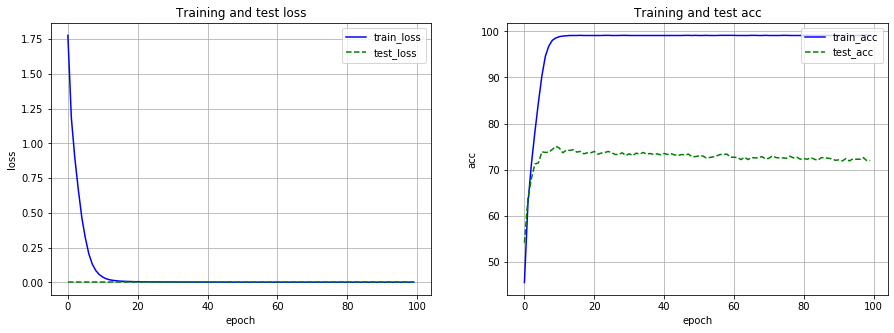

In [22]:
#plt.plot(train_loss_list)
plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(range(num_epochs), train_loss_list, color='blue', linestyle='-', label='train_loss')
plt.plot(range(num_epochs), test_loss_list, color='green', linestyle='--', label='test_loss')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Training and test loss')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(num_epochs), train_acc_list, color='blue', linestyle='-', label='train_acc')
plt.plot(range(num_epochs), test_acc_list, color='green', linestyle='--', label='test_acc')
plt.legend(loc="upper right")
plt.xlabel('epoch')
plt.ylabel('acc')
plt.title('Training and test acc')
plt.grid()